# Project 2: Linear Regression – California Wildfires (Part 2: Mo

# Libraries and Options

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import patsy

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV, LinearRegression, Lasso, LassoCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Configure Options & Settings at Interpreter Startup

In [2]:
def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 100,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 25,
#             'max_seq_items': 25,       # Max length of printed sequence
            'precision': 5,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

if __name__ == '__main__':
    start()
    del start  # Clean up namespace in the interpreter

# Load Data

In [3]:
df = pd.read_pickle('data/wildfire_pre_eda.pickle')
# Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1364
Data columns (total 19 columns):
unique_id          1341 non-null object
name               1341 non-null object
acresburned        1341 non-null float64
started            1341 non-null datetime64[ns]
extinguished       1341 non-null datetime64[ns]
calfireincident    1341 non-null object
majorincident      1341 non-null int64
durationdays       1341 non-null int64
dewpoint           1341 non-null float64
humidity           1341 non-null float64
moonphase          1341 non-null float64
precipintensity    1341 non-null float64
sunsettime         1341 non-null float64
temperaturehigh    1341 non-null float64
temperaturelow     1341 non-null float64
windspeed          1341 non-null float64
latitude           1341 non-null float64
longitude          1341 non-null float64
month              1341 non-null int64
dtypes: datetime64[ns](2), float64(11), int64(3), object(3)
memory usage: 209.5+ KB


# Transforming Y term

## Transformation of 'acresburned' (highly skewed)

### Box-cox

In [ ]:
# lamb = stats.boxcox_normmax(df['acresburned'], brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
# print("Lambda:", lamb)
# y_t = (np.power(df['acresburned'],-0.2282)-1)/-0.2282
# df['acresburned_boxcox'] = (np.power(df['acresburned'],-0.2282)-1)/-0.2282

# plt.hist(y_t);

In [4]:
df['acresburned_log'] = np.log(df['acresburned']) 

In [64]:
# import plotly.io as pio
# import plotly.express as px
# pio.renderers.default = "notebook"
fig = px.histogram(df, x='acresburned_log',
                   title='Histogram of Acres Burned (log)',
                   labels={'acresburned_log':'Acres burned (log)'}, # can specify one label per df column
                   opacity=0.8,
                   log_y=False, # represent bars with log scale
                   color_discrete_sequence=['indianred'] # color of histogram bars
                   )

fig.show()



(array([  1., 187., 393., 342., 160., 120.,  70.,  32.,  28.,   8.]),
 array([ 0.69314718,  1.91627321,  3.13939923,  4.36252526,  5.58565128,
         6.80877731,  8.03190334,  9.25502936, 10.47815539, 11.70128141,
        12.92440744]),
 <a list of 10 Patch objects>)

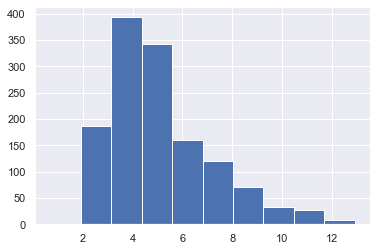

In [41]:
plt.hist(df['acresburned_log'])

## Reorder columns

In [5]:
df = df[[
    'acresburned_log', 'acresburned', 'unique_id', 'name', 'started',
    'month', 'extinguished', 'calfireincident', 'majorincident',
    'durationdays', 'dewpoint', 'humidity', 'moonphase', 'precipintensity',
    'sunsettime', 'temperaturehigh', 'temperaturelow', 'windspeed', 'latitude',
    'longitude', 
]]

# Identify correlations

In [15]:
df.corr()['acresburned_log'].sort_values(ascending=False)

acresburned_log    1.00000
acresburned        0.49029
majorincident      0.31663
month              0.07894
latitude           0.07164
windspeed          0.06279
temperaturelow     0.00364
moonphase          0.00235
temperaturehigh   -0.00451
precipintensity   -0.01505
longitude         -0.02698
durationdays      -0.05972
sunsettime        -0.12131
humidity          -0.13132
dewpoint          -0.14160
Name: acresburned_log, dtype: float64

In [ ]:
# Choose the predictor variables, here all but the first which is the response variable
predictor_variables = [
    'majorincident', 
    'windspeed', 
    'month', 
    'latitude', 
#     'moonphase', 
#     'temperaturelow',
#     'temperaturehigh', 
#     'longitude', 
#     'precipintensity',
#     'durationdays', 
#     'humidity',
#     'dewpoint', 
    'sunsettime'
]

X = df.loc[:, predictor_variables]

# Choose the response variable(s)
y = df.loc[:, 'acresburned_log']

# Fit the model to the full dataset
lr.fit(X, y)

In [ ]:
# View the correlations
df.corr()

In [ ]:
# example of a better corr matrix
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

### Correlation and Multicollinearity

In [ ]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df); # height=1.2, aspect=1.5

# Train/Test

## Define predictor variables and y-term

In [6]:
# Choose the predictor variables, here all but the first which is the response variable
predictor_variables = [
    'majorincident', 
    'windspeed', 
    'month', 
    'latitude', 
#     'moonphase', 
#     'temperaturelow',
#     'temperaturehigh', 
#     'longitude', 
#     'precipintensity',
#     'durationdays', 
#     'humidity',
#     'dewpoint', 
    'sunsettime'
]

X = df.loc[:, predictor_variables]

# Choose the response variable(s)
y = df.loc[:, 'acresburned_log']

## Split the data 80 - 20  train/test

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [17]:
X_train.shape

(804, 5)

# Standardize data using standard scaler

In [19]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [21]:
# plt.hist(X_tr[:,3])

## OLS model

In [40]:
# lasso_model = sm.OLS(y_train, sm.add_constant(X_tr))
# results = lasso_model.fit()

# results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        acresburned_log   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     21.14
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           6.96e-20
Time:                        17:05:43   Log-Likelihood:                -1697.8
No. Observations:                 804   AIC:                             3408.
Df Residuals:                     798   BIC:                             3436.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1562      0.071     72.854      0.000       5.017       5.295
x1             0.5945      0.072      8.255      0.000       0.453       0.736
x2             0.1706      0.074      2.293      0.022       0.025       0.317
x3             0.1871      0.072      2.591      0.010       0.045       0.329
x4             0.1350      0.071      1.892      0.059      -0.005       0.275
x5            -0.2605      0.076     -3.439      0.001      -0.409      -0.112
==============================================================================
Omnibus:                      111.550   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.983
Skew:                           1.000   Prob(JB):                     3.00e-35
Kurtosis:                       3.866   Cond. No.                         1.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# # lasso_model = Lasso(alpha = .1) # already ran in Scaling
# lasso_model.fit(X_train.loc[:,predictor_variables], y_train)
# list(zip(predictor_variables, lasso_model.coef_))

In [ ]:
# test_set_pred = lasso_model.predict(X_test.loc[:, predictor_variables])

## Fit a LASSO model on the standardized data

In [70]:
lasso_model = Lasso(alpha = .1)
lasso_model.fit(X_tr, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
list(zip(X_train.columns, lasso_model.coef_))

[('majorincident', 0.5305249952641311),
 ('windspeed', 0.0144902636287349),
 ('month', 0.07024884421613688),
 ('latitude', 0.033946132148180624),
 ('sunsettime', -0.10605076922357218)]

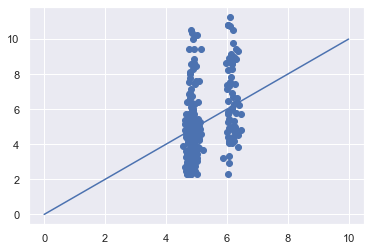

In [72]:
y_predict = lasso_model.predict(X_te)
plt.scatter(y_predict, y_test)
plt.plot([0, 10], [0, 10])

In [80]:
# fig = px.scatter(x=y_predict, y=y_test)
fig = px.scatter(x=y_predict, y=y_test, trendline="ols",
                   title='Linear Regression ',
                   opacity=0.8,
                   color_discrete_sequence=['indianred'] # color of histogram bars
                   )
fig.show()

In [32]:
#r-squared
r2_score(y_test, y_predict)

0.14257424035691346

In [35]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, y_predict) # acres burned (needs to be exponentiated)

1.4290370805070884

## Ridge model

In [ ]:
lr_model_ridge = Ridge(alpha = .1)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

In [ ]:
lr_model_ridge = Ridge(alpha = .1)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

# Cross Validation (KFold)

## K-Fold in a less manual way

In [65]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.08798061, 0.05603649, 0.14266538, 0.15957992, 0.07245905])

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.11147020629647475


NameError: name 'lm_reg' is not defined

In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

mean_cv_scores = []

# def collect_scores(scores):
#     for score in scores:
#         mean_cv_scores.append(score)
        
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.11147020629647475


NameError: name 'lm_reg' is not defined

# [TBD] Tuning Regularization Strength via Validation

In [ ]:
alphalist = 10**(np.linspace(-2, 2, 200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process
    steps = [('standardize', StandardScaler()),
             ('ridge', Ridge(alpha=curr_alpha))] # Changed from Lasso

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:, predictor_variables].values, y_train)

    val_set_pred = pipe.predict(X_val.loc[:, predictor_variables].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [ ]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [ ]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)
# Lasso == 22552 & Ridge == 22555

In [ ]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]
# Lasso == 20.72 & Ridge == .01

## Lasso Cross Validation

In [ ]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

In [ ]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

# ridge_model = RidgeCV(alphas=alphavec, cv=5)
# ridge_model.fit(X_tr, y_train)

In [ ]:
# This is the best alpha value it found - not far from the value
lasso_model.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, lasso_model.coef_))
list(zip(X_train.columns, ridge_model.coef_))

In [ ]:
# Make predictions on the test set using the new model
# test_set_pred = lasso_model.predict(X_te)
test_set_pred = ridge_model.predict(X_te)

## Find the MAE and R^2 on the test set using this model

In [ ]:
mae(y_test, test_set_pred)

In [ ]:
r2_score(y_test, test_set_pred)

# [TBD] Residuals vs Predicted

Look at prediction of the residuals

In [ ]:
(y_pred - y_true)